<a href="https://colab.research.google.com/github/aayushkubb/nlp/blob/main/QUORA_Class_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount the drive

Please make sure the below folder is added to your drive

https://drive.google.com/drive/folders/1wcwKLy8SFu4iugPhzJNovpwvzyIQPP_D?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Problem Definition
---
I think one of the important things when you start a new machine learning project is Defining your problem. that means you should understand business problem.( Problem Formalization)

> We will be predicting whether a question asked on Quora is sincere or not

Data Source : https://www.kaggle.com/c/quora-insincere-questions-classification/data

**About Quora**

Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.

**Business View**

An existential problem for any major website today is how to handle toxic and divisive content. Quora wants to tackle this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.

**What is a insincere question?**

Is defined as a question intended to make a statement rather than look for helpful answers.

<img src="https://drive.google.com/uc?id=1XOvVoEDjNF_p2tHV1H9XzoZHxfzBBA5t"/>

**Feature Set**

We use train.csv and test.csv as Input and we should upload a submission.csv as Output.

The training set contains the following 3 features (for Supervised Learning)
1. qid - unique question identifier
2. question_text - Quora question text
3. target - a question labeled "insincere" has a value of 1, otherwise 0

In [2]:
!pip install nltk


# Import Statements

In [78]:
import pandas as pd
import numpy as np
import nltk
import re


from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords


from sklearn.metrics import classification_report
# nltk.download('all')

# Read the datasets

In [91]:
train=pd.read_csv('/content/drive/MyDrive/Quora/QuoratrainSet.csv')
test=pd.read_csv('/content/drive/MyDrive/Quora/Quoratestdata.csv')

In [92]:
train.shape, test.shape

((1048575, 3), (375806, 2))

In [93]:
#Just for the class we will sample
train=train.sample(frac=.01)
test=test.sample(frac=.01)

In [94]:
train.head()

,qid,question_text,target
218787,2acca501f5e0e623984a,Why do people store your number in their phone...,0
385172,4b74856dbb6440ca161f,How do I stop using self-deprecation as a defe...,0
384097,4b42d55656fb3dc1e7bd,What is your opinion of the politicians in the...,0
197093,26885b2aff395a4b7b3d,I will start to learn programming. Should I st...,0
873728,ab2e0c85825ffb0f61ce,What do you do when your boyfriends mother str...,0


In [95]:
test.head()

,qid,question_text
363681,f7dcd18dde867df3ce8b,"How many electrons will flow, if the (current ..."
160148,6cff4b50f00745c97482,How can I take advantage of my appearance wisely?
57774,27569a217de574015257,Where can I browse and get an online job in Au...
17789,0c0d2afef5135a414646,Do Lyft and Uber drivers actually make money a...
187490,7f8d8cf8dfe3418c85ff,How much time it requires to update?


In [96]:
train['target'].value_counts(normalize=True)

0    0.936677
1    0.063323
Name: target, dtype: float64

# Approach



1.   Try to understand the data a bit.
    *   Patterns - NGRAMs
    *   EDA - WORDCLOUD

2. Success Criteria - F1 score  
3. Baseline Approach
4. Clean the data
      *   Lowercase
      *   Tokeniser
      *   Remove Stopwords
      *   Remove non-apha text
      *   Lemmatisation/Stemming

5. Prepare the data for training
      *   Word to numeric features - Count and TFIDF 
      *   Standardize these features

6. Build our model
7. Evaluate and Repeat of required






In [97]:
def ngram_finder(tokens):
  bigrams = nltk.collocations.BigramAssocMeasures()
  bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)

  #bigrams
  bigram_freq = bigramFinder.ngram_fd.items()
  bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
  


  trigrams = nltk.collocations.TrigramAssocMeasures()
  trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)

  #trigrams
  trigram_freq = trigramFinder.ngram_fd.items()
  trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
  

  return bigramFreqTable,trigramFreqTable


# Basic Data Cleaning

In [98]:
characters=[]
for i in train['question_text'].tolist():
  for j in i.split():
    for k in j:
      characters.append(k)

In [99]:
re.sub('[^a-z ]',"","hey this, is me 123 ?")

'hey this is me  '

In [117]:
#STopwords
Stopwords = set(stopwords.words('english'))
Stopwords.add("a")


def data_cleaner(row):

  '''Cleaner utility for text'''

  #lowercasing
  row=row.lower()
  # print(row)

  #Remove anything apart from alphabets
  row=re.sub('[^a-z ]',"",row)
  # print(row)

  #Strip
  row=row.strip()
  # print(row)

  #Lets remove stopwords
  row=" ".join([i for i in row.split() if i not in Stopwords])
  # print(row)
  return row





In [118]:
train['question_text']=train['question_text'].apply(data_cleaner)

In [119]:
train=train[train['question_text'].apply(lambda x: len(x.split())>=2)]

In [120]:
# Tokeniser
tokens=[]
for i in train.loc[train['target']==1,'question_text']:
  tokens.extend(nltk.word_tokenize(i.lower()))

for i in tokens:
  if i in Stopwords:
    tokens.remove(i)
bigramFreqTable,trigramFreqTable=ngram_finder(tokens)
bigramFreqTable

,bigram,freq
317,"(donald, trump)",7
1371,"(black, people)",6
647,"(prime, minister)",5
1080,"(gun, control)",5
520,"(white, people)",5
...,...,...
1953,"(go, away)",1
1952,"(hillary, go)",1
1951,"(wont, hillary)",1
1950,"(religion, wont)",1


In [121]:
# Tokeniser
tokens=[]
for i in train.loc[train['target']==0,'question_text']:
  tokens.extend(nltk.word_tokenize(i.lower()))

for i in tokens:
  if i in Stopwords:
    tokens.remove(i)
bigramFreqTable,trigramFreqTable=ngram_finder(tokens)
bigramFreqTable

,bigram,freq
1552,"(best, way)",58
1359,"(year, old)",33
1053,"(would, happen)",31
300,"(whats, best)",28
15,"(united, states)",26
...,...,...
19857,"(respected, european)",1
19858,"(european, nations)",1
19859,"(nations, st)",1
19861,"(century, favorite)",1


In [122]:
train['length_sentence']=train['question_text'].apply(lambda x: len(x.split()))

In [123]:
train.groupby(by='target').describe()

length_sentence                                ... predictions_baseline                    
                 count      mean       std  min  25%  ...                  min  25%  50%  75%  max
target                                                ...                                         
0               9755.0  6.287852  3.492159  2.0  4.0  ...                  0.0  0.0  0.0  0.0  1.0
1                664.0  8.941265  5.045600  2.0  5.0  ...                  0.0  0.0  0.0  0.0  1.0

[2 rows x 16 columns]

In [76]:
#Baseline Model

In [126]:
train['predictions_baseline']=train['length_sentence'].apply(lambda x: 1 if x>13 else 0)

In [127]:
print(classification_report(train['target'],train['predictions_baseline']))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      9755
           1       0.20      0.17      0.18       664

    accuracy                           0.90     10419
   macro avg       0.57      0.56      0.56     10419
weighted avg       0.90      0.90      0.90     10419



In [128]:
#lets check on the test set


In [130]:
test['question_text']=test['question_text'].apply(data_cleaner)
test['length_sentence']=test['question_text'].apply(lambda x: len(x.split()))
test['predictions_baseline']=test['length_sentence'].apply(lambda x: 1 if x>13 else 0)

In [131]:
test.loc[test['predictions_baseline']==1,'question_text'].tolist()

['ex reconnected suddenly disappeared saying going rehab hes liar pine feel love someone treated poorly cant even contact',
 'many driving licence offices predominantly africanamerican hispanic communities closed since beginning number differ number dl offices closing predominantly white neighborhoods',
 'less common principle good painting good music good martial arts etc advice principles intersect arts science life general',
 'since two days ago every sound loud almost hurts cant stand even quiet sounds stop',
 'prince charles secretly frustrated mother queen elizabeth taking long time depart another world finally become king',
 'citizens united give special privledges power society dont pay taxes inheritance willing commit treason',
 'owning gun reason give address get chip dont remember thatd make easier buy guns',
 'think changes surface ones really deep ones harder make laziness lying oneself stupidity youth combination',
 'resident aliens fh list cars turo tired asking end read

# Visualisation

In [132]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

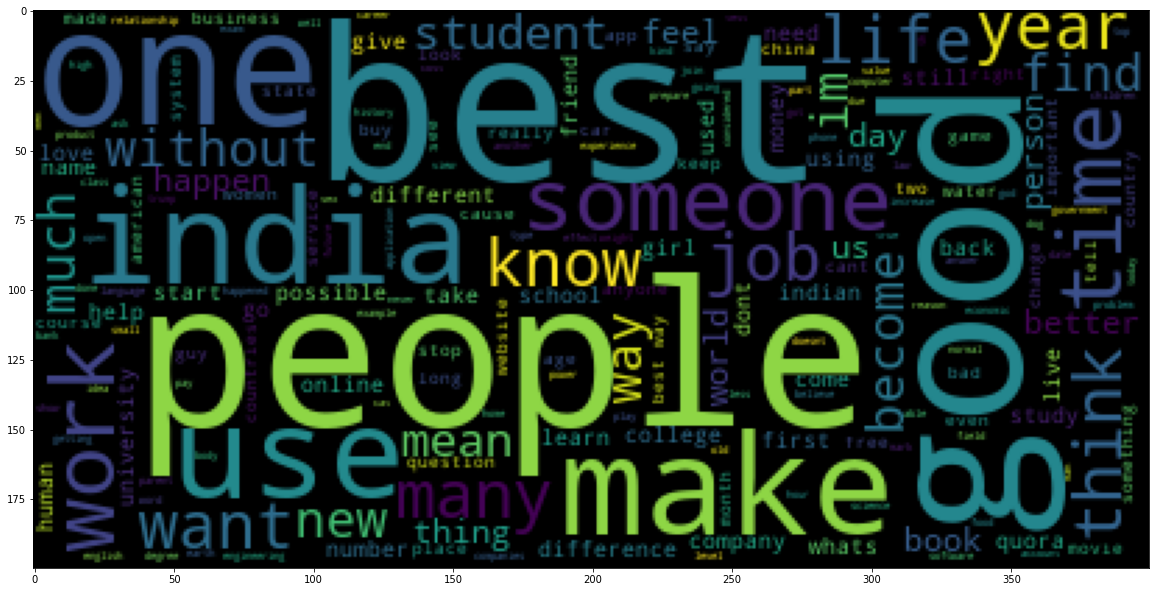

In [139]:
# Sincere
wc=WordCloud().generate(" ".join(train.loc[train['target']==0,'question_text'].tolist()))
fig = plt.figure(1, figsize = (20, 20))
plt.imshow(wc)
plt.show()

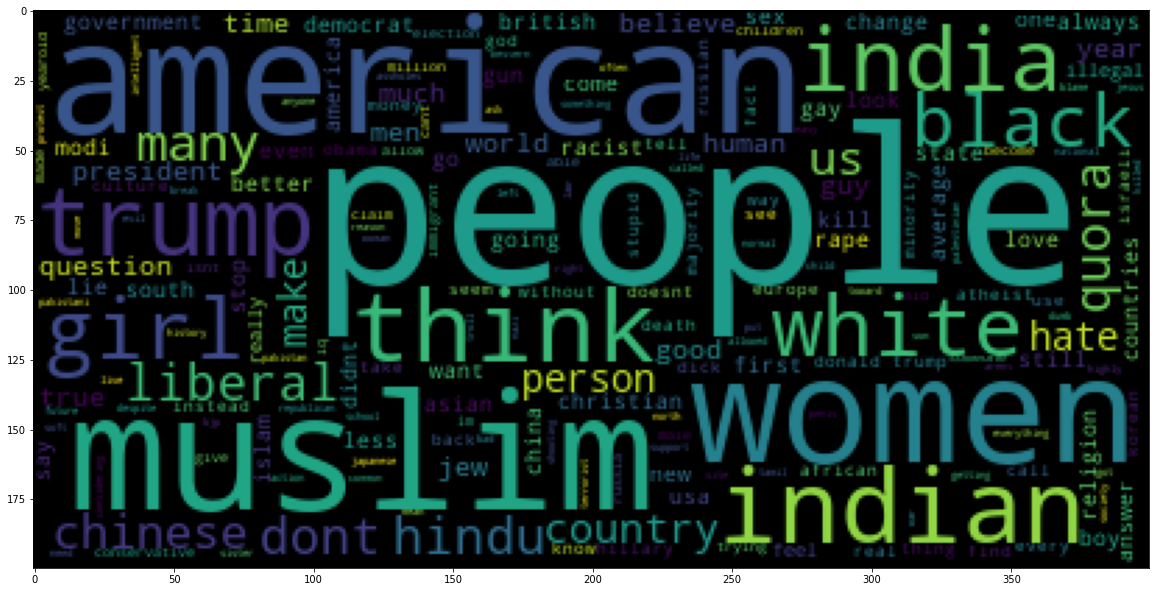

In [140]:
# InSincere
wc=WordCloud().generate(" ".join(train.loc[train['target']==1,'question_text'].tolist()))
fig = plt.figure(1, figsize = (20, 20))
plt.imshow(wc)
plt.show()